In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [29]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

Text(0.5, 1.0, 'bull_mastiff prob [0.9613395]')

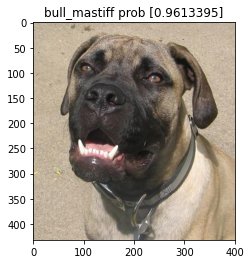

In [110]:
def load_image(filename):
    file_content = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(file_content)
    img = img[None, ...]
    return img

def preprocess_image(img):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img
    
def make_prediction(img, adv_pattern = None, adv_intensity=0):
    img = preprocess_image(img)
    
    if(adv_intensity):
        img = img + adv_pattern * adv_intensity;

    predict = pretrained_model.predict(img)        
    
    prediction_idx = tf.argmax(predict, axis=1)
    prediction_proba = predict[0, prediction_idx]
    prediction_class = "unk"
    pred_temp = tf.keras.applications.mobilenet_v2.decode_predictions(predict)
    
    return pred_temp[0][0][1], prediction_idx, prediction_proba

img1 = load_image("./images/3.png")

prediction_class, prediction_idx, prediction_proba = make_prediction(img1)
plt.imshow(img1[0])
plt.title("{} prob {}".format(prediction_class, prediction_proba))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


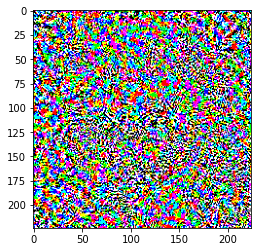

In [111]:
loss_func = tf.losses.CategoricalCrossentropy()

def create_adversarial_pattern(img):
    img = preprocess_image(img)
    predict = pretrained_model(img)
    predict_idx = tf.argmax(predict, axis=1)
    predict_shape = tf.shape(predict)
    label = tf.one_hot(indices=predict_idx, depth=predict_shape[1])
    
    with tf.GradientTape() as tape:
        tape.watch(img)
        predicted_classes = pretrained_model(img)
        loss = loss_func(label, predicted_classes)
    
    gradient = tape.gradient(loss, img)
    result = tf.sign(gradient)
    return result

adv_pattern = create_adversarial_pattern(img1)
plt.imshow(adv_pattern[0])

Text(0.5, 1.0, 'Great_Dane prob [0.07049057]')

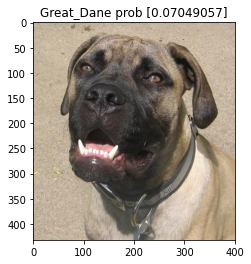

In [112]:
prediction_class, prediction_idx, prediction_proba = make_prediction(img1, adv_pattern, 0.02)
plt.imshow(img1[0])
plt.title("{} prob {}".format(prediction_class, prediction_proba))